# Fine-tuning Smart-Assist Image Captioning model

The purpose of creating a fine-tuned Image Captioning model is to enable the chatbot model to identify features that are implicitly mentioned in the text but not explicitly stated. This could include attributes like color, shape, size, material, etc.

## Installing and Importing Libraries

In [53]:
from datasets import load_dataset, load_from_disk

In [55]:
import datasets
import transformers
print(datasets.__version__)
print(transformers.__version__)

2.18.0
4.37.0.dev0


## Loading the dataset

In [1]:
# Path to the folder containing the data
root = r"C:/Users/likhi/Documents/02 Pycharm Datasets/01 Master Thesis/06b Image_Captioning_Dataset/imagefolder/"

In [2]:
import os

# Set the environment variable ARROW_LARGE_MEMORY_TEST to '20GB'
os.environ['ARROW_LARGE_MEMORY_TEST'] = '200GB'

block_size = os.environ.get('ARROW_LARGE_MEMORY_TEST')
print(block_size)

200GB


#### Loading train dataset

In [54]:
train_dataset = load_from_disk(os.path.join(root, 'train_dataset'))
print("Train Dataset:")
print(train_dataset)

Loading dataset from disk:   0%|          | 0/37 [00:00<?, ?it/s]

Train Dataset:
Dataset({
    features: ['image', 'text'],
    num_rows: 551662
})


#### Loading validation dataset

In [48]:
val_dataset = load_from_disk(os.path.join(root, 'val_dataset', 'val_dataset'))
print("Validation Dataset:")
print(val_dataset)

Resolving data files:   0%|          | 0/183990 [00:00<?, ?it/s]

Validation Dataset:
Dataset({
    features: ['image', 'text'],
    num_rows: 183989
})


#### Loading test dataset

In [14]:
test_dataset = load_from_disk(os.path.join(root, 'test_dataset', 'test_dataset'))
print("Test Dataset:")
print(test_dataset)

Resolving data files:   0%|          | 0/183166 [00:00<?, ?it/s]

Test Dataset:
Dataset({
    features: ['image', 'text'],
    num_rows: 183165
})


## Create PyTorch dataset

In [22]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding


from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [23]:
train_dataset = ImageCaptioningDataset(train_dataset, processor)
val_dataset = ImageCaptioningDataset(val_dataset, processor)
test_dataset = ImageCaptioningDataset(test_dataset, processor)

item = train_dataset[0]
for k,v in item.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Creating PyTorch Dataloader

In [42]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

# Define a collate function to pad sequences within each batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    
    max_length = max(len(input_ids) for input_ids in batch)

    # Pad sequences to the maximum length within the batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=max_length)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'pixel_values': pixel_values}

# Create DataLoader with custom collate function
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=512, collate_fn=collate_fn)

# Iterate over batches
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

input_ids torch.Size([512, 896])
attention_mask torch.Size([512, 896])
pixel_values torch.Size([512, 3, 224, 224])


In [43]:
processor.decode(batch["input_ids"][0])
print(len(batch["input_ids"][0]))

896


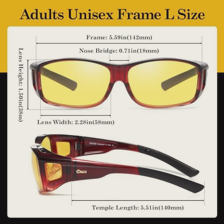

In [44]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

### Defining the model

In [45]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [46]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss


KeyboardInterrupt



## Training the model

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
losses = []

for epoch in range(100):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    losses.append(loss)

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

## Inference

DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x1a\x00\x00\x00'


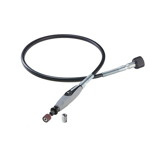

'dremel flex shaft rotary tool attachment with comfort grip and 36” long cable engraver polisher and mini sander ideal for detail metal engraving wood carving and jewelry polishing 22502 greytools home improvementdremel holiday deals25 off 125 tight spots nooks and corners theyre all easily within reach when you add the 225 flexshaft attachment to your dremel rotary tool flexible 36inch shaft attaches easily enabling craftsman jewelers woodworkers and diyers the extended control and flexibility to drill cut carve and polish even the most delicate of projects compatible with dremel rotary tool models 4300 4000 3000 200 100 8260 8250 8240 and 8220 ideal for diy or crafting projects like detail sanding carving engraving cutting cleaning and polishing integrated shaft lock button on the hand piece allows for easy accessory changes comfort grip hand piece allows finger tip control to cut grind sand sharpen polish and more quick connect easily attaches to your dremel rotary tool'

In [46]:
example = train_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

example["text"]

In [47]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

perler pegboards ironing paper and polishing ironing paper and polishing material is ironing paper and polishing is metalic with the perler bead ironing paper and polish


In [ ]:
# Save the model
model.save_pretrained(root + 'saved_models/')